# PPO and ProcGen notebook

In this notebook a runnable code (with some exceptions) is accessible, first the import of neccessary packages and code snippest from the repository are imported. Setting up the parameters for the training loop and running the training loop with different setups is performed. The information gained from training (updated policy) are then used to play on unseen data and the results plotted.

## Index

* [1. Setup and training](#setuptrain)<br>
    * [1.1 Training loop](#training)<br>
* [2. Augmentation Display](#data_aug)<br>
    * [2.1 Grayscale](#randgray)<br>
    * [2.2 Color-Jitter](#colorjitter)<br>
    * [2.3 Cut-out](#cutout)<br>
    * [2.4 Mixreg](#mixreg)<br>
* [3. Training and test results](#traintest)<br>

<a id='setuptrain'></a>
## Setup and training

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. Python scripts including functions for data augmentations are imported for later use.

In [13]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
!wget https://raw.githubusercontent.com/hlynurarni/Deep_learning_02456_FProject/master/HPC%20Scripts/data_aug.py
!wget https://raw.githubusercontent.com/hlynurarni/Deep_learning_02456_FProject/master/HPC%20Scripts/TransformLayer.py

--2020-12-27 18:08:21--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]  14.46K  --.-KB/s    in 0s      

2020-12-27 18:08:22 (53.2 MB/s) - ‘utils.py.1’ saved [14807/14807]

--2020-12-27 18:08:22--  https://raw.githubusercontent.com/hlynurarni/Deep_learning_02456_FProject/master/HPC%20Scripts/data_aug.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4697 (4.6K) [t

Hyperparameters, the value can be changed. For ease of read and to showcase a working notebook 20.000 steps are made for few different combinations. The test and train results in <a id='traintest'></a> are based on 8e6 steps. Initial values, which are a good starting point can be seen in comments for each parameter.

In [3]:
# Hyperparameters
total_steps = 8e6 # 8e6
num_envs = 32 # 32
num_levels = 100 # 10
num_steps = 256 # 256
num_epochs = 3 # 3
batch_size = 512 # 512
eps = .2 # .2
grad_eps = .5 # .5
value_coef = .5 # .5
entropy_coef = .01 # .01

To store the data the gdrive is mounted, this can be altered and changed based on the user.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The policy network using popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. Here the neccessary libraries are imported, along with the data agumentations functions from the imported python files.

In [15]:
# Add the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from utils import make_env, Storage, orthogonal_init
from data_aug import RandGray,random_color_jitter,random_cutout
from time import time

Implementation of the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) minus the LSTM.

In [6]:
# Impala encoder
#  Added instead of the given Encoder 
def xavier_uniform_init(module, gain=1.0):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight.data, gain)
        nn.init.constant_(module.bias.data, 0)
    return module

class ResidualBlock(nn.Module):
    def __init__(self,in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = nn.ReLU()(x)
        out = self.conv1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImpalaBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.res1 = ResidualBlock(out_channels)
        self.res2 = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class Encoder(nn.Module):
    def __init__(self,in_channels,out_features,**kwargs):
        super().__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(in_features=32 * 8 * 8, out_features=out_features)

        self.output_dim = feature_dim
        self.apply(xavier_uniform_init)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = nn.ReLU()(x)
        x = Flatten()(x)
        x = self.fc(x)
        x = nn.ReLU()(x)
        return x


In [7]:
# Function to display images 
def imshow(img):
    """ show an image """
    plt.figure(figsize=(10,8))
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Encoder2(nn.Module):
    def __init__(self, in_channels, feature_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
        )
        self.apply(orthogonal_init)

    def forward(self, x):
        return self.layers(x)

class Policy(nn.Module):
    def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

    def act(self, x):
        with torch.no_grad():
            x = x.cuda().contiguous()
            dist, value = self.forward(x)
            action = dist.sample()
            log_prob = dist.log_prob(action)

        return action.cpu(), log_prob.cpu(), value.cpu()

    def forward(self, x):
        x = self.encoder(x)
        logits = self.policy(x)
        value = self.value(x).squeeze(1)
        dist = torch.distributions.Categorical(logits=logits)

        return dist, value

In [9]:
#  Example runs
setup_run = {
    'Run1': {
      'Encoder':'regular',
      'Data_aug': 'regular',
      'Mixreg': False,
      'Policy': None
    }
}

setup_run['Run2'] = {
    'Encoder':'impala',
    'Data_aug': 'regular',
    'Mixreg': False,
    'Policy': None
}

setup_run['Run3'] = {
    'Encoder':'impala',
    'Data_aug': 'grayscale',
    'Mixreg': False,
    'Policy': None
}

setup_run['Run4'] = {
    'Encoder':'impala',
    'Data_aug': 'color_jitter',
    'Mixreg': False,
    'Policy': None
}

setup_run['Run5'] = {
    'Encoder':'impala',
    'Data_aug': 'cut_out',
    'Mixreg': False,
    'Policy': None
}

<a id='training'></a>
### Training loop

In [16]:
#  ============================       RUNNING LOOP      ==============================

run_setups =['Run1','Run2','Run3','Run4','Run5'] # Specify a list of setups to run

for run in run_setups: # Run the training for all our setups
    # Define environment
    # check the utils.py file for info on arguments
    env_name = 'starpilot'
    env = make_env(num_envs, num_levels=num_levels, env_name='starpilot')
    print('Observation space:', env.observation_space)
    print('Action space:', env.action_space.n)
    print(f'Run setup for {run}: playing {env_name}')
    for setup_key in setup_run[run]:
        print(f'{setup_key}: {setup_run[run][setup_key]}', end = '\t')
    print('')

    # Read in the setup
    do_mixreg = setup_run[run]['Mixreg']
    data_aug = setup_run[run]['Data_aug']
    encoder_use = setup_run[run]['Encoder']

    # Define network
    feature_dim = 512
    lambda_mix = 0.95
    num_actions = env.action_space.n
    in_channels = env.observation_space.shape[0]

    # Define the encoder
    if encoder_use == 'impala':
        print('Using Impala') 
        encoder = Encoder(in_channels, feature_dim) # added
    else:
        encoder = Encoder2(in_channels, feature_dim) # added

    # Initialize the policy
    policy = Policy(encoder, feature_dim, num_actions) # added
    policy.cuda()

    # Define optimizer
    # these are reasonable values but probably not optimal
    optimizer = torch.optim.Adam(policy.parameters(), lr=5e-4, eps=1e-5)

    # Define temporary storage
    # we use this to collect transitions during each iteration
    storage = Storage(
          env.observation_space.shape,
          num_steps,
          num_envs
      )

    # Run training
    obs = env.reset()
    nenv = env.num_envs
    device = torch.device('cpu')

    # Change the first observations to desired augmentation
    if data_aug == 'grayscale':
        obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
        obs[:] = env.reset()

        # Do the grayscale and transfer to tensor
        augs_funcs = RandGray(batch_size=num_envs, p_rand=1) # added
        obs = augs_funcs.do_augmentation(obs)
        obs = torch.from_numpy(obs)
    elif data_aug == 'random_cutout':
        # Initialize as a numpy array then convert to tensor
        obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
        obs[:] = env.reset()

        # Do the cutout and transfer to tensor
        obs = random_cutout(obs,12,24)
        obs = torch.from_numpy(obs)
    elif data_aug == 'color_jitter':
        obs = random_color_jitter(obs,p=0.5)

    step = 0
    # Initilize mean_reward for each setup that we store in the end
    mean_rewards = []
    mean_rewards_done = []
    first_loop = True
    start = time() # Lets measure how long each training task takes
    while step < total_steps:
        # Use policy to collect data for num_steps steps
        policy.eval()
        for _ in range(num_steps):
            # Use policy
            action, log_prob, value = policy.act(obs)

            # Take step in environment
            next_obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)

            # numpy obs
            next_obs[:], reward, done, info = env.step(action)

            # Store data
            storage.store(obs, action, reward, done, info, log_prob, value)

            # Make augmented transformation, probably possible to do this another way, like in a class to avoid the if statements
            if data_aug == 'grayscale':
                obs = augs_funcs.do_augmentation(next_obs)
                obs = torch.from_numpy(obs)
            elif data_aug == 'random_cutout':
                obs = random_cutout(next_obs,12,24)
                obs = torch.from_numpy(obs)
            elif data_aug == 'color_jitter':
                obs = torch.from_numpy(next_obs)
                obs = random_color_jitter(obs,p=0.5)
            else:
                obs = torch.from_numpy(next_obs)


        # Add the last observation to collected data
        _, _, value = policy.act(obs)
        storage.store_last(obs, value)

        # Compute return and advantage
        storage.compute_return_advantage()

        # Optimize policy
        policy.train()
        for epoch in range(num_epochs):

            # Iterate over batches of transitions
            generator = storage.get_generator(batch_size)
            for batch in generator:
                b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

                if do_mixreg: 
                    index_ij = torch.randint(0, batch_size-1, (batch_size,2))
                    b_obs = lambda_mix*b_obs[index_ij[:,0]] + (1-lambda_mix)*b_obs[index_ij[:,1]]
                    b_log_prob = lambda_mix*b_log_prob[index_ij[:,0]] + (1-lambda_mix)*b_log_prob[index_ij[:,1]]
                    b_value = lambda_mix*b_value[index_ij[:,0]] + (1-lambda_mix)*b_value[index_ij[:,1]]
                    b_returns = lambda_mix*b_returns[index_ij[:,0]] + (1-lambda_mix)*b_returns[index_ij[:,1]]
                    b_advantage = lambda_mix*b_advantage[index_ij[:,0]] + (1-lambda_mix)*b_advantage[index_ij[:,1]]
                    if (lambda_mix >= 0.5):
                        b_action = b_action[index_ij[:,0]]
                    else:
                        b_action = b_action[index_ij[:,1]]

            # Get current policy outputs
            new_dist, new_value = policy(b_obs)
            new_log_prob = new_dist.log_prob(b_action)

            # Clipped policy objective
            ratio = torch.exp(new_log_prob - b_log_prob) # added
            # ratio = b_log_prob/new_log_prob # added
            clipped_ratio = ratio.clamp(min=1.0 - eps,max=1.0 + eps) # added
            # pi_loss = torch.min(rt_theta*b_advantage,) # added
            pi_loss = -torch.min(ratio * b_advantage,clipped_ratio * b_advantage).mean() # added

            # Clipped value function objective
            clipped_value = b_value + (new_value - b_value).clamp(min=-eps, max=eps) # added
            # value_loss = (new_value - b_value)**2 # added
            value_loss = 0.5 * torch.max((b_value - b_returns) ** 2, (clipped_value - b_returns) **2).mean() # added

            # Entropy loss
            entropy_loss = -new_dist.entropy().mean() # added

            # Backpropagate losses
            loss = pi_loss + value_coef*value_loss + entropy_coef*entropy_loss # added
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps) # added

            # Update policy
            optimizer.step()
            optimizer.zero_grad()

        # Update stats
        mean_rewards.append(storage.get_reward(normalized_reward=False))
        done_reward = sum((sum(storage.reward)/(sum(storage.done)+1)))/num_envs

        # TODO: If you never die implement an if statement that doesn't include the plus 1
        mean_rewards_done.append(done_reward)
        step += num_envs * num_steps
        print(f'Step: {step}\tMean reward: {storage.get_reward(normalized_reward=False)}, \tMean reward done: {done_reward}')
        if first_loop:
            end = time()
            time_total = end-start
            estimated_time = (8e6/(8192/time_total))/3600
            print(f'Estimated time of completion: {estimated_time} hours')
        first_loop = False
        
    # While loop ended, save results
    end = time()
    time_total = end-start
    
    # Save the newest version after every epoch
    torch.save({
              'Setup': setup_run[run], # Have 
              'policy_state_dict': policy.state_dict(), # This is the policy
              'encoder_state_dict': encoder.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(), # The optimizer used
              'Mean Reward': mean_rewards,
              'Mean Reward Done': mean_rewards_done,
              'Training time': time_total,
              }, f'/content/gdrive/MyDrive/Deep Learning Project 2020/data/{run}.pt')
    print(f'Completed training of {run}!')
    torch.save(policy.state_dict(), f'{run}_policy.pt')

print('Completed all runs!')

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
Run setup for Run1: playing starpilot
Encoder: regular	Data_aug: regular	Mixreg: False	Policy: None	
Step: 8192	Mean reward: 8.401390075683594, 	Mean reward done: 2.391955614089966
Estimated time of completion: 3.1214913017013006 hours
Completed training of Run1!
Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
Run setup for Run2: playing starpilot
Encoder: impala	Data_aug: regular	Mixreg: False	Policy: None	
Using Impala
Step: 8192	Mean reward: 8.384974479675293, 	Mean reward done: 2.3830788135528564
Estimated time of completion: 4.3119494027147685 hours
Completed training of Run2!
Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15
Run setup for Run3: playing starpilot
Encoder: impala	Data_aug: grayscale	Mixreg: False	Policy: None	
Using Impala
Step: 8192	Mean reward: 8.401407241821289, 	Mean reward done: 2.3919591903686523
Estimated time of completion: 4.396456578332517

<a id='data_aug'></a>
## Data augmentation examples

For clarification on how the augmentations work the code for the different methods is included. This code is imported in [Setup and training](#setuptrain)<br> and the games Coinrun and Dodgeball are used to showcase the augmented data.

<a id='randgray'></a>
### Grayscaling

In [ ]:
# Randomly grascale an envorinment observation space, the p value can be adjusted for the probability of a figure being grascaled
class RandGray(object):
    def __init__(self,  
                 batch_size, 
                 p_rand=0.5,
                 *_args, 
                 **_kwargs):
        
        self.p_gray = p_rand
        self.batch_size = batch_size
        self.random_inds = np.random.choice([True, False], 
                                            batch_size, 
                                            p=[self.p_gray, 1 - self.p_gray])
        
    def grayscale(self, imgs):
        # imgs: b x h x w x c
        # the format is incorrect
        b, c, h, w = imgs.shape # format changed, hlynur
        imgs = imgs[:, 0, :, :] * 0.2989 + imgs[:, 1, :, :] * 0.587 + imgs[:, 2, :, :] * 0.114 
        imgs = np.tile(imgs.reshape(b,-1,h,w), (1, 3, 1, 1)) # .astype(np.uint8)
        return imgs

    def do_augmentation(self, images):
        # images: [B, C, H, W]
        bs, channels, h, w = images.shape
        # print(images.shape)
        if self.random_inds.sum() > 0:
            # print(self.random_inds)
            # print(sum(self.random_inds))
            # print(images[self.random_inds].shape)
            images[self.random_inds] =  self.grayscale(images[self.random_inds])

        return images
    
    def change_randomization_params(self, index_):
        self.random_inds[index_] = np.random.choice([True, False], 1, 
                                                    p=[self.p_gray, 1 - self.p_gray])
        
    def change_randomization_params_all(self):
        self.random_inds = np.random.choice([True, False], 
                                            self.batch_size, 
                                            p=[self.p_gray, 1 - self.p_gray])
        
    def print_parms(self):
        print(self.random_inds)


In [ ]:
games = ['coinrun','dodgeball']

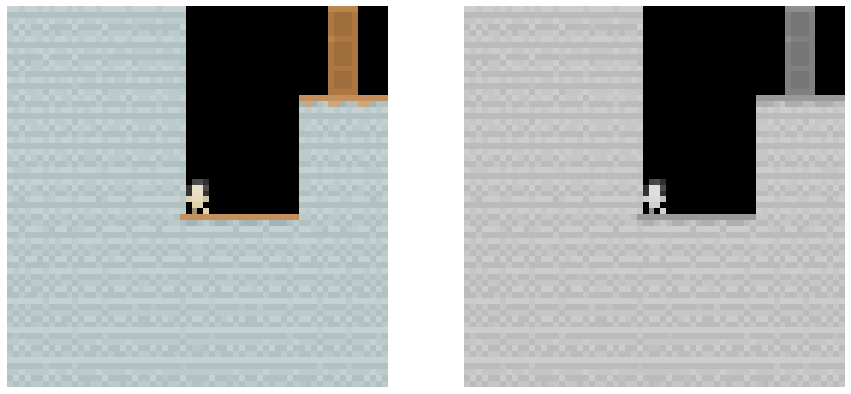

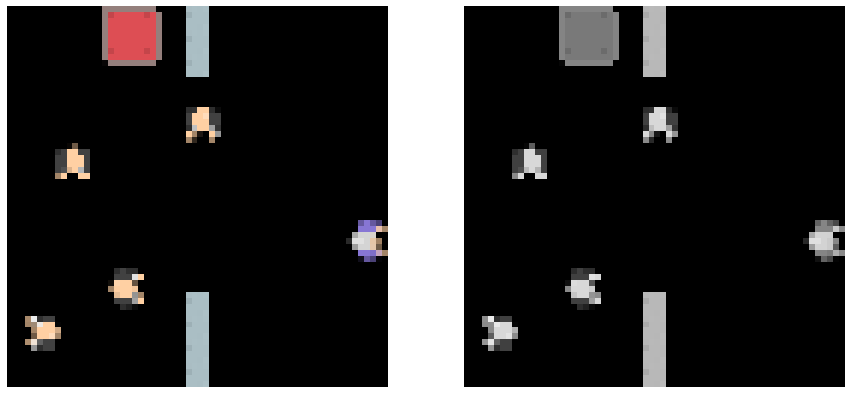

In [ ]:
# How to use the RandGray class
path = '/content/gdrive/MyDrive/Deep Learning Project 2020/data/aug_figures/'
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    nenv = env.num_envs # added
    obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));


    # Do the augmentation
    augs_funcs = RandGray(batch_size=num_envs, p_rand=1) # added
    obs = augs_funcs.do_augmentation(obs)
    sample = obs[0,:,:,:]

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}grayscale_{game}.png')

<a id='colorjitter'></a>
# Random Color Jitter

In [ ]:
# taken from: https://github.com/MishaLaskin/rad/blob/1246bfd6e716669126e12c1f02f393801e1692c1/TransformLayer.py#L87

# Repository has to be public to be able to import functions from it

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import numbers
import random
import time


def rgb2hsv(rgb, eps=1e-8):
    # Reference: https://www.rapidtables.com/convert/color/rgb-to-hsv.html
    # Reference: https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L287

    _device = rgb.device
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]

    Cmax = rgb.max(1)[0]
    Cmin = rgb.min(1)[0]
    delta = Cmax - Cmin

    hue = torch.zeros((rgb.shape[0], rgb.shape[2], rgb.shape[3])).to(_device)
    hue[Cmax== r] = (((g - b)/(delta + eps)) % 6)[Cmax == r]
    hue[Cmax == g] = ((b - r)/(delta + eps) + 2)[Cmax == g]
    hue[Cmax == b] = ((r - g)/(delta + eps) + 4)[Cmax == b]
    hue[Cmax == 0] = 0.0
    hue = hue / 6. # making hue range as [0, 1.0)
    hue = hue.unsqueeze(dim=1)

    saturation = (delta) / (Cmax + eps)
    saturation[Cmax == 0.] = 0.
    saturation = saturation.to(_device)
    saturation = saturation.unsqueeze(dim=1)

    value = Cmax
    value = value.to(_device)
    value = value.unsqueeze(dim=1)

    return torch.cat((hue, saturation, value), dim=1)#.type(torch.FloatTensor).to(_device)
    # return hue, saturation, value

def hsv2rgb(hsv):
    # Reference: https://www.rapidtables.com/convert/color/hsv-to-rgb.html
    # Reference: https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L287

    _device = hsv.device

    hsv = torch.clamp(hsv, 0, 1)
    hue = hsv[:, 0, :, :] * 360.
    saturation = hsv[:, 1, :, :]
    value = hsv[:, 2, :, :]

    c = value * saturation
    x = - c * (torch.abs((hue / 60.) % 2 - 1) - 1)
    m = (value - c).unsqueeze(dim=1)

    rgb_prime = torch.zeros_like(hsv).to(_device)

    inds = (hue < 60) * (hue >= 0)
    rgb_prime[:, 0, :, :][inds] = c[inds]
    rgb_prime[:, 1, :, :][inds] = x[inds]

    inds = (hue < 120) * (hue >= 60)
    rgb_prime[:, 0, :, :][inds] = x[inds]
    rgb_prime[:, 1, :, :][inds] = c[inds]

    inds = (hue < 180) * (hue >= 120)
    rgb_prime[:, 1, :, :][inds] = c[inds]
    rgb_prime[:, 2, :, :][inds] = x[inds]

    inds = (hue < 240) * (hue >= 180)
    rgb_prime[:, 1, :, :][inds] = x[inds]
    rgb_prime[:, 2, :, :][inds] = c[inds]

    inds = (hue < 300) * (hue >= 240)
    rgb_prime[:, 2, :, :][inds] = c[inds]
    rgb_prime[:, 0, :, :][inds] = x[inds]

    inds = (hue < 360) * (hue >= 300)
    rgb_prime[:, 2, :, :][inds] = x[inds]
    rgb_prime[:, 0, :, :][inds] = c[inds]

    rgb = rgb_prime + torch.cat((m, m, m), dim=1)
    rgb = rgb.to(_device)

    return torch.clamp(rgb, 0, 1)

class ColorJitterLayer(nn.Module):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0, p=0, batch_size=128, stack_size=3):
        super(ColorJitterLayer, self).__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)
        self.prob = p
        self.batch_size = batch_size
        self.stack_size = stack_size
        
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))
        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value
    
    def adjust_contrast(self, x):
        """
            Args:
                x: torch tensor img (rgb type)
            Factor: torch tensor with same length as x
                    0 gives gray solid image, 1 gives original image,
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.contrast)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        means = torch.mean(x, dim=(2, 3), keepdim=True)
        return torch.clamp((x - means)
                           * factor.view(len(x), 1, 1, 1) + means, 0, 1)
    
    def adjust_hue(self, x):
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.hue)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        h = x[:, 0, :, :]
        h += (factor.view(len(x), 1, 1) * 255. / 360.)
        h = (h % 1)
        x[:, 0, :, :] = h
        return x
    
    def adjust_brightness(self, x):
        """
            Args:
                x: torch tensor img (hsv type)
            Factor:
                torch tensor with same length as x
                0 gives black image, 1 gives original image,
                2 gives the brightness factor of 2.
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.brightness)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        x[:, 2, :, :] = torch.clamp(x[:, 2, :, :]
                                     * factor.view(len(x), 1, 1), 0, 1)
        return torch.clamp(x, 0, 1)
    
    def adjust_saturate(self, x):
        """
            Args:
                x: torch tensor img (hsv type)
            Factor:
                torch tensor with same length as x
                0 gives black image and white, 1 gives original image,
                2 gives the brightness factor of 2.
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.saturation)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        x[:, 1, :, :] = torch.clamp(x[:, 1, :, :]
                                    * factor.view(len(x), 1, 1), 0, 1)
        return torch.clamp(x, 0, 1)
    
    def transform(self, inputs):
        hsv_transform_list = [rgb2hsv, self.adjust_brightness,
                              self.adjust_hue, self.adjust_saturate,
                              hsv2rgb]
        rgb_transform_list = [self.adjust_contrast]
        # Shuffle transform
        if random.uniform(0,1) >= 0.5:
            transform_list = rgb_transform_list + hsv_transform_list
        else:
            transform_list = hsv_transform_list + rgb_transform_list
        for t in transform_list:
            inputs = t(inputs)
        return inputs
    
    def forward(self, inputs):
        _device = inputs.device
        random_inds = np.random.choice(
            [True, False], len(inputs), p=[self.prob, 1 - self.prob])
        inds = torch.tensor(random_inds).to(_device)
        if random_inds.sum() > 0:
            inputs[inds] = self.transform(inputs[inds])
        return inputs

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning Project 2020/data/aug_figures/'
def random_color_jitter(imgs,p=0.5):
    """
        imgs,p=0.5
        inputs np array outputs tensor, HLYNUR: this is wrong we input a tensor
    """
    brightness = round(random.uniform(0.1, 1.0),4)
    contrast = round(random.uniform(0.1, 1.0),4)
    saturation = round(random.uniform(0.1, 1.0),4)
    hue = round(random.uniform(0.1, 1.0),4)
    test = random.randint(1,1000)
    # print(f'brightness:{brightness}, contrast:{contrast}, saturation:{saturation}, hue:{hue}, test:{test}')

    b,c,h,w = imgs.shape
    imgs = imgs.view(-1,3,h,w)
    transform_module = nn.Sequential(ColorJitterLayer(brightness=brightness, 
                                                contrast=contrast,
                                                saturation=saturation,
                                                hue=hue,
                                                p=p,
                                                batch_size=num_envs,
                                                stack_size=1))

    imgs = transform_module(imgs).view(b,c,h,w)
    return imgs

brightness:0.86, contrast:0.7822, saturation:0.4785, hue:0.333, test:524
brightness:0.86, contrast:0.7822, saturation:0.4785, hue:0.333, test:524


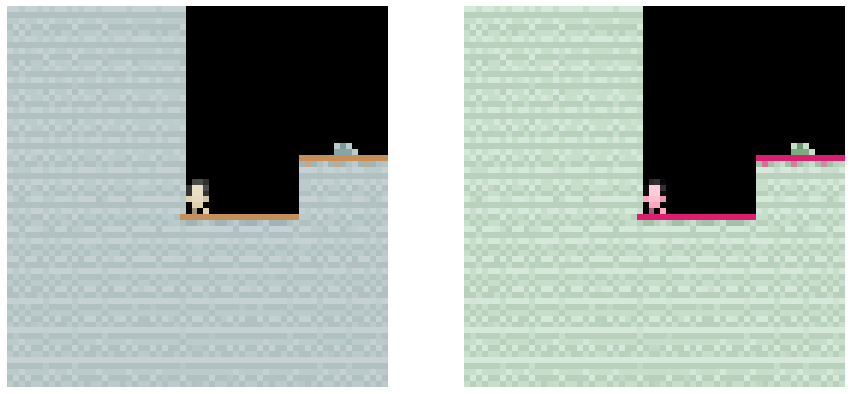

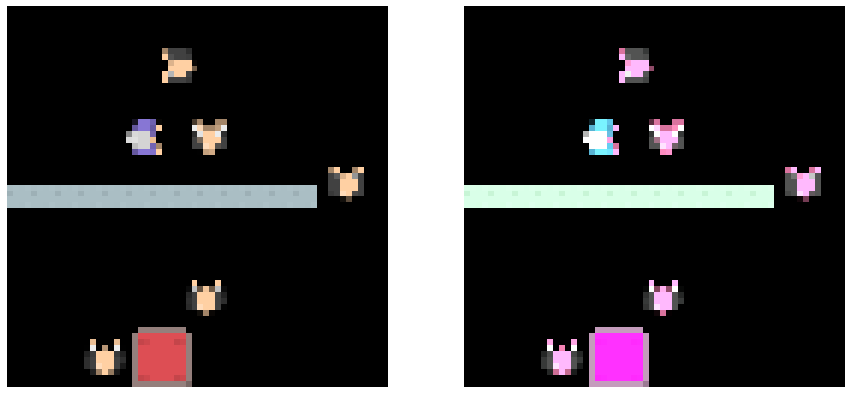

In [ ]:
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    obs = env.reset()

    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));

    # Do the augmentation
    obs = random_color_jitter(obs,p=1)

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}color_jitter{game}.png')

<a id='cutout'></a>
# Random cutout

In [ ]:
# This is not an inplacement function like the others 

device = torch.device('cpu')
def random_cutout(imgs, min_cut,max_cut):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        #print(img[:, h11:h11 + h11, w11:w11 + w11].shape)
        cutouts[i] = cut_img
    return cutouts

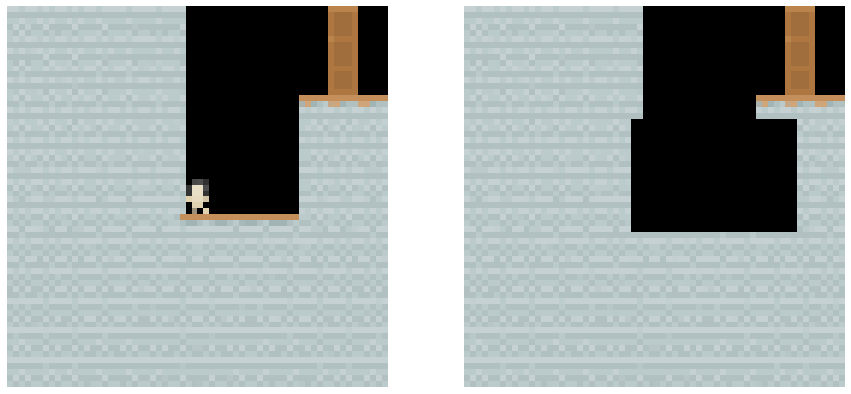

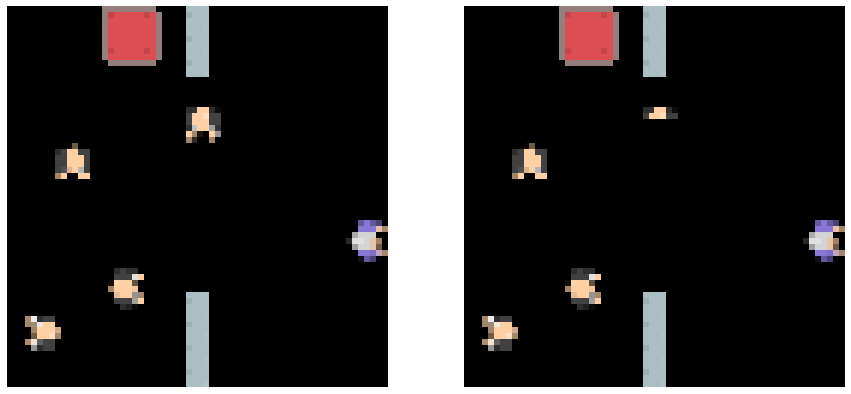

In [ ]:
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    nenv = env.num_envs # added
    obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));

    # Do the augmentation
    obs = random_cutout(obs,16,32)
    sample = obs[0,:,:,:]

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}rand_cutout{game}.png')

<a id='mixreg'></a>
# Mixreg

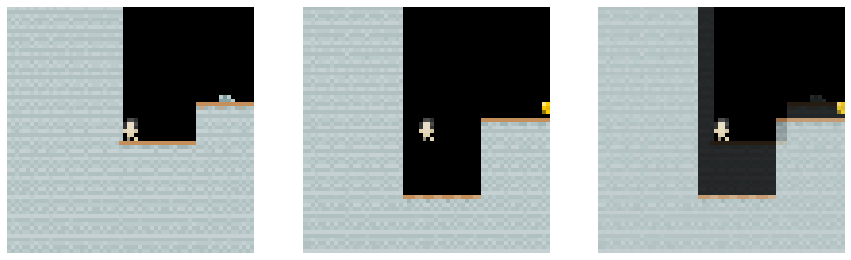

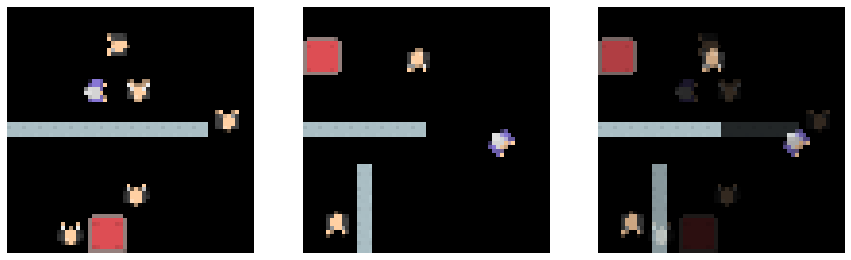

In [ ]:
num_levels = 10
for game in games:
    env_1 = make_env(1, num_levels=10, env_name=game)
    num_actions = env.action_space.n
    obs = env_1.reset()
    sample = obs[0,:,:,:]

    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));

    env_2 = make_env(1, start_level=20, num_levels=10, env_name=game)
    num_actions = env.action_space.n
    obs = env_2.reset()

    for x in range(20):
    action = random.randint(1, num_actions)
    action = torch.tensor((action,), dtype=torch.int32)
    # action = np.int32(action)
    obs, reward, done, info = env_2.step(action)

    plt.subplot(1, 3, 2)
    plt.axis('off')
    sample_2 = obs[0,:,:,:]
    plt.imshow(np.transpose(sample_2, (1, 2, 0)));


    plt.subplot(1, 3, 3)
    plt.axis('off')
    new_obs = sample*0.2 + sample_2*0.8
    plt.imshow(np.transpose(new_obs, (1, 2, 0)));
    plt.savefig(f'{path}mixreg{game}.png')

<a id='traintest'></a>
## Training and test results

In [ ]:
# We store the mean rewards each num_envs * num_steps steps
# Steps taken in M
steps_taken = np.arange(num_envs*num_steps,
                        int(np.ceil(total_steps/(num_envs*num_steps)))*num_envs*num_steps+1,
                        num_envs*num_steps)/1000000

In [ ]:
def decode_experiment_name(name):
    components = name.split('_')
    experiment_name = 'Nature'
      if components[1] == 'i':
    experiment_name = '3 Impala'
      elif components[1] == '1':
    experiment_name = '1 Impala'
      if components[2] == 'mx':
    experiment_name += ': Mix Reg'
      elif components[2] == 'rc':
    experiment_name += ': Rand Cut' 
      elif components[2] == 'cj':
    experiment_name += ': Col Jit'
      elif components[2] == 'addfc':
    experiment_name += ': Add FCL' 
      return experiment_name

In [ ]:
# Function that plots the training mean reward as a function of steps for
# each experiment of a specific game
def plot_training_performance(game_name, shows_subset=False, subset_to_run=[],
                              med_text_size=10, big_text_size=12):
    path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

    # Get the stored rewards for each experiment
    rewards = []
    experiment_names = []
    for filename in os.listdir(path):
        if filename.endswith(".pt"):
            experiment_names.append(filename)
            file_load = torch.load(path + filename)
            rewards.append(file_load['Mean Reward'])
    print('Number of experiments done for ' + game_name + ': ' + str(len(experiment_names)))
    print('Experiment names: ' + str(experiment_names))

    # Set plot text size
    #plt.rc('font', size=SMALL_SIZE)          # Controls default text sizes
    plt.rc('axes', titlesize=med_text_size)     # Fontsize of the axes title
    plt.rc('axes', labelsize=med_text_size)     # Fontsize of the x and y labels
    plt.rc('xtick', labelsize=med_text_size)    # Fontsize of the tick labels
    plt.rc('ytick', labelsize=med_text_size)    # Fontsize of the tick labels
    plt.rc('legend', fontsize=med_text_size)    # Legend fontsize
    plt.rc('figure', titlesize=big_text_size)   # Fontsize of the figure title

    # Plot the mean rewards for each experiment
    plt.figure(figsize = (16, 10))
    for i in range(len(experiment_names)):
        if shows_subset:
            if decode_experiment_name(experiment_names[i]) in subset_to_run:
                mean_rewards = [r.item() for r in rewards[i]] # From tensores to a list of reward values
                plt.plot(steps_taken, mean_rewards, label=decode_experiment_name(experiment_names[i]))
        else:
            mean_rewards = [r.item() for r in rewards[i]] # From tensores to a list of reward values
            plt.plot(steps_taken, mean_rewards, label=decode_experiment_name(experiment_names[i]))
    plt.legend()
    plt.xlabel('Steps (M)')
    plt.ylabel('Mean Reward')
    plt.title(game_name + ' Training Rewards')
    plt.show()

Number of experiments done for Starpilot: 14
Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']


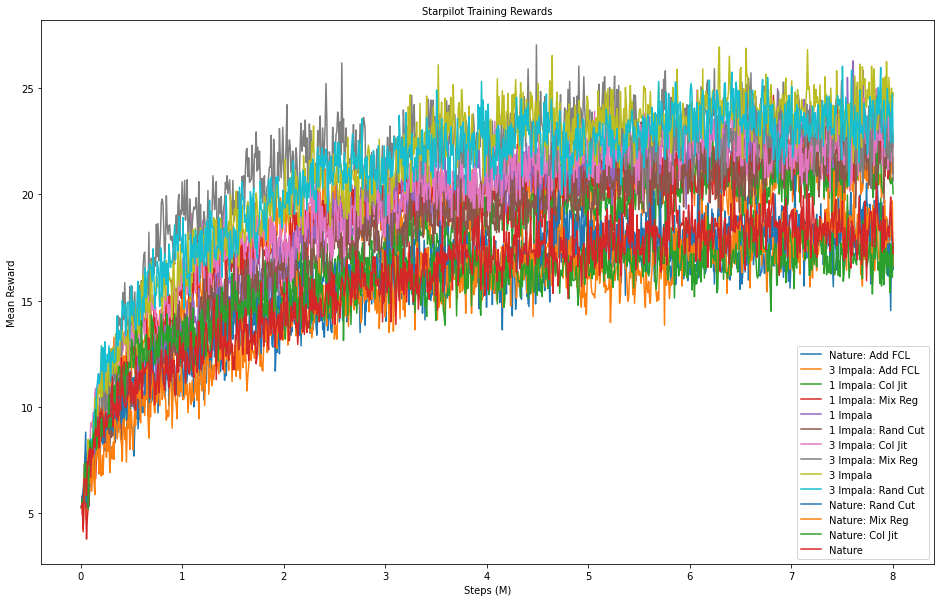

In [ ]:
plot_training_performance('Starpilot')

Number of experiments done for Starpilot: 14
Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']


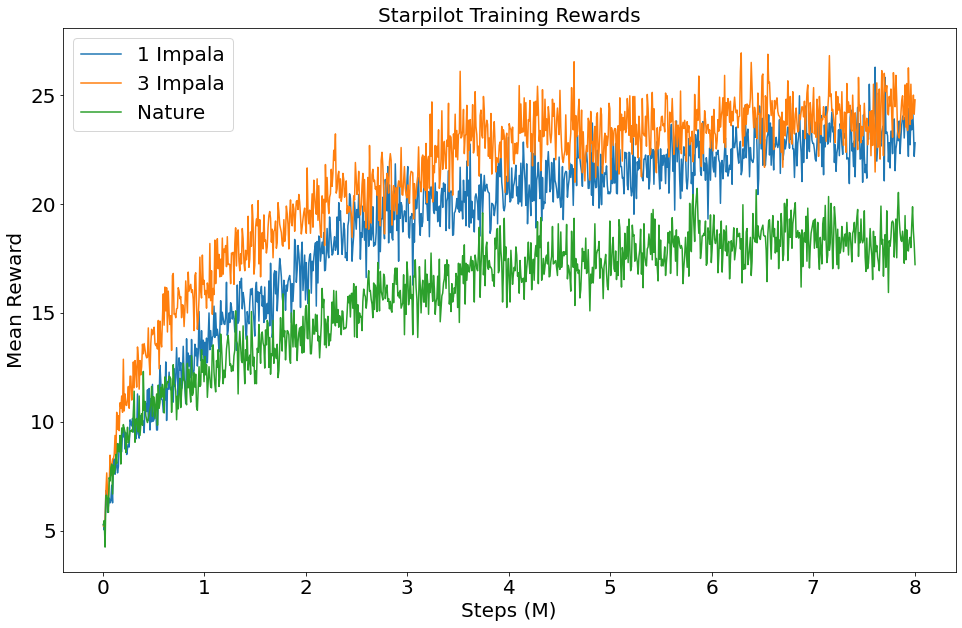

In [ ]:
# Run different encoders
plot_training_performance('Starpilot', shows_subset=True, subset_to_run=['Nature', '1 Impala', '3 Impala'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Starpilot: 14
Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']


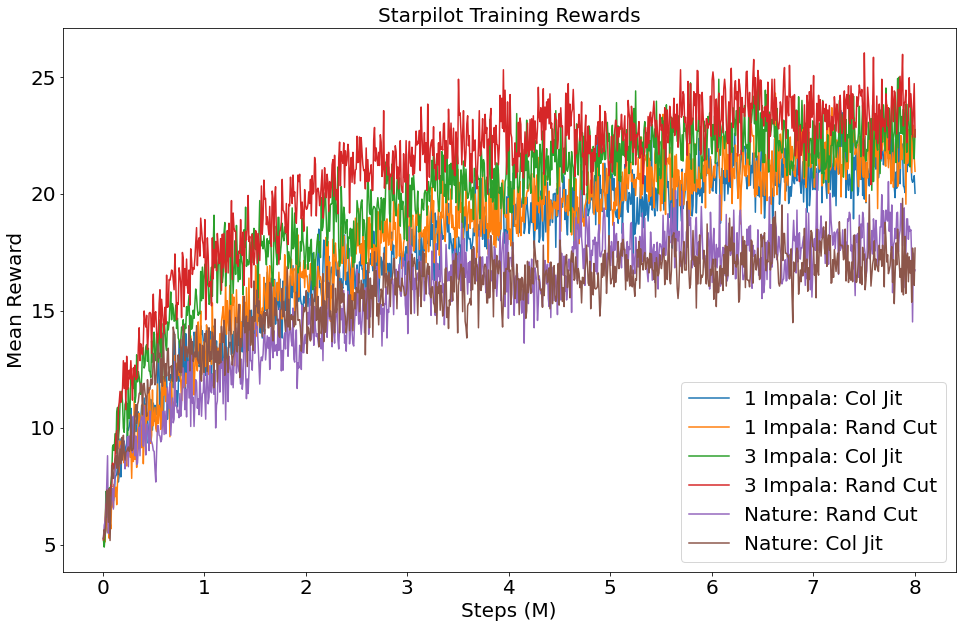

In [ ]:
# Run different data augmentations
plot_training_performance('Starpilot', shows_subset=True,
                          subset_to_run=['Nature: Col Jit', 'Nature: Rand Cut',
                                         '1 Impala: Col Jit', '1 Impala: Rand Cut', 
                                         '3 Impala: Col Jit', '3 Impala: Rand Cut'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Starpilot: 14
Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']


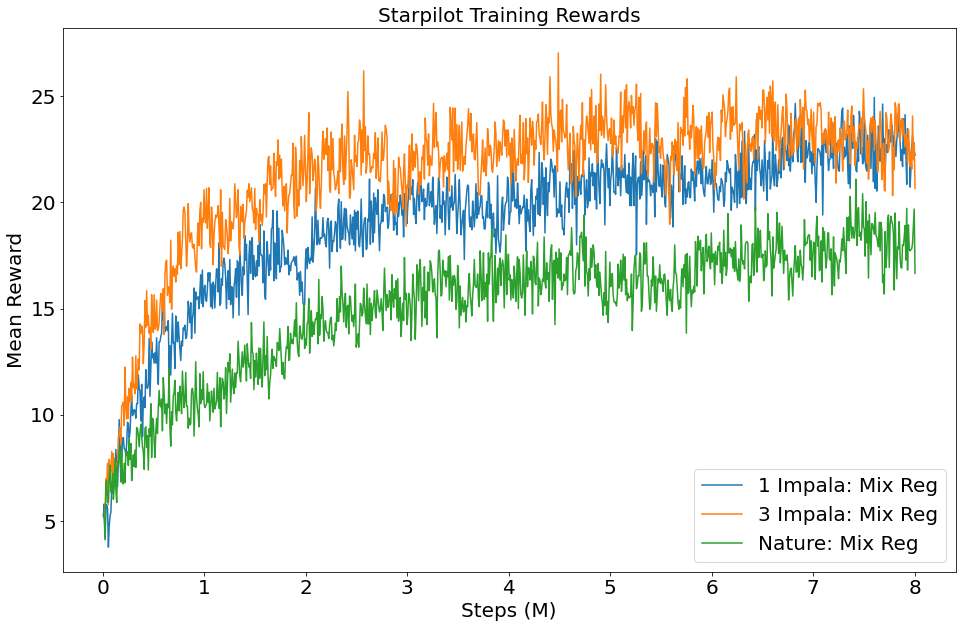

In [ ]:
# Run Mix reg
plot_training_performance('Starpilot', shows_subset=True,
                          subset_to_run=['Nature: Mix Reg', '1 Impala: Mix Reg', '3 Impala: Mix Reg'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Starpilot: 14
Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']


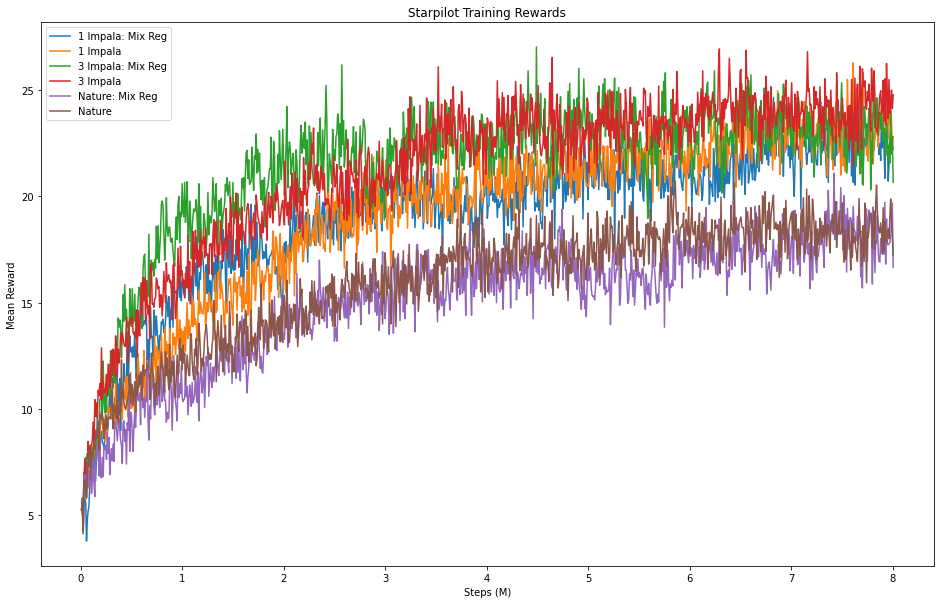

In [ ]:
plot_training_performance('Starpilot', shows_subset=True, subset_to_run=['Nature', '1 Impala', '3 Impala', 'Nature: Mix Reg', '1 Impala: Mix Reg', '3 Impala: Mix Reg']) 

Number of experiments done for Coinrun: 14
Experiment names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']


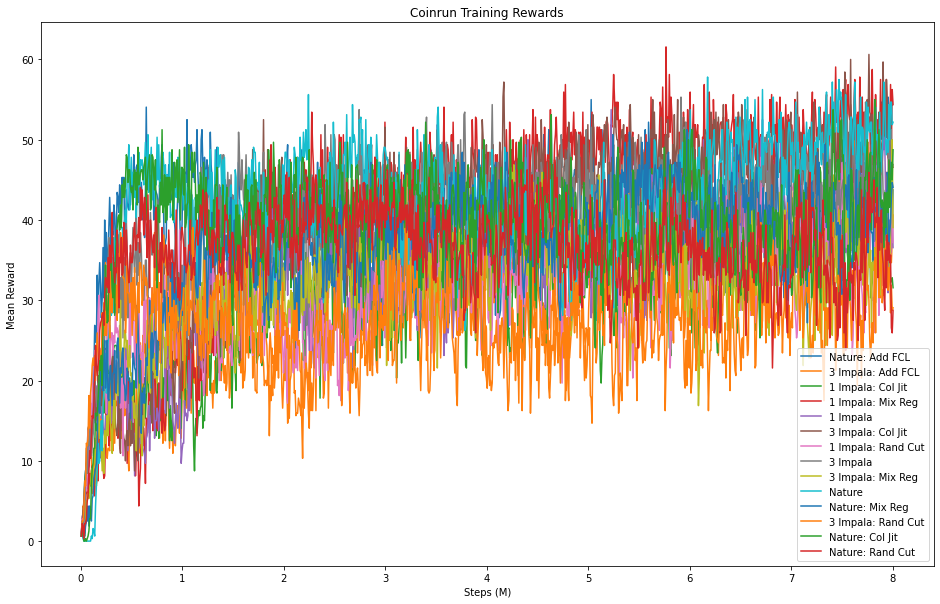

In [ ]:
plot_training_performance('Coinrun')

Number of experiments done for Coinrun: 14
Experiment names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']


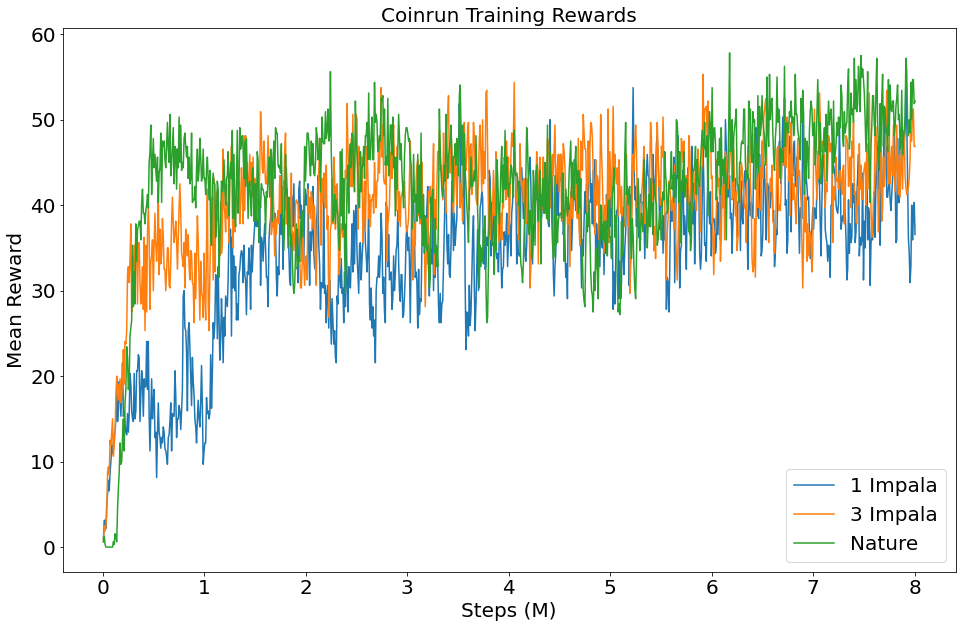

In [ ]:
# Run different encoders
plot_training_performance('Coinrun', shows_subset=True, subset_to_run=['Nature', '1 Impala', '3 Impala'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Coinrun: 14
Experiment names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']


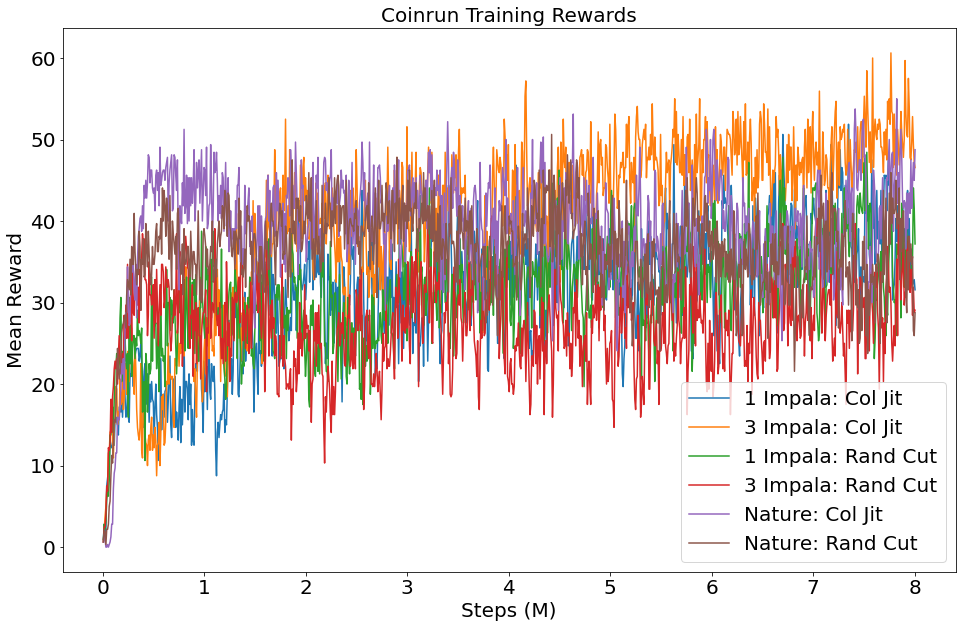

In [ ]:
# Run different data augmentations
plot_training_performance('Coinrun', shows_subset=True,
                          subset_to_run=['Nature: Col Jit', 'Nature: Rand Cut', '1 Impala: Col Jit', '1 Impala: Rand Cut', '3 Impala: Col Jit', '3 Impala: Rand Cut'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Coinrun: 14
Experiment names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']


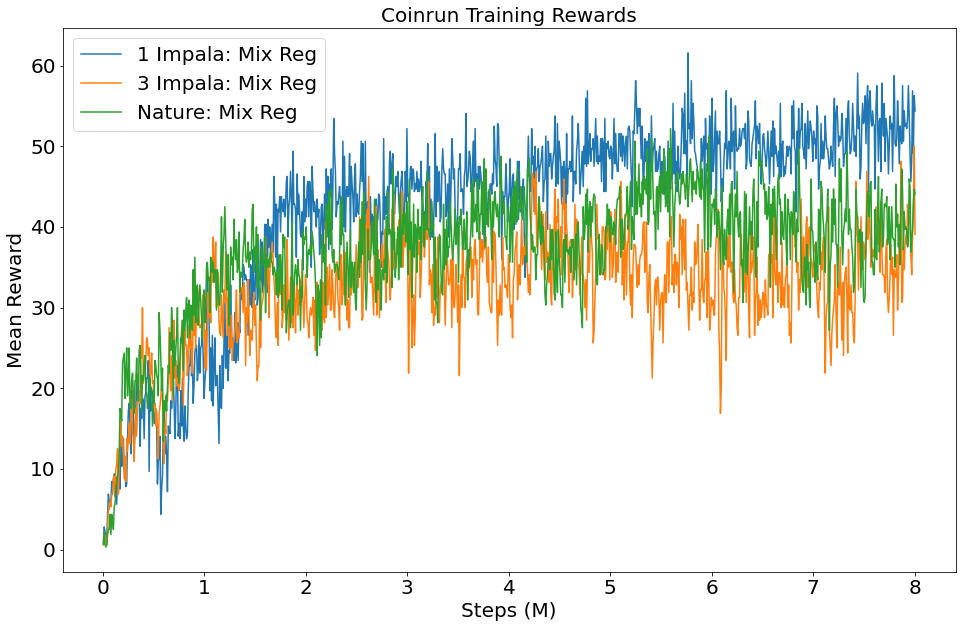

In [ ]:
# Run Mix reg
plot_training_performance('Coinrun', shows_subset=True, subset_to_run=['Nature: Mix Reg', '1 Impala: Mix Reg', '3 Impala: Mix Reg'],
                          med_text_size=20, big_text_size=25) 

Number of experiments done for Dodgeball: 12
Experiment names: ['sd_1_cj_db.pt', 'sd_1_mx_db.pt', 'sd_1_na_db.pt', 'sd_1_rc_db.pt', 'sd_i_mx_db.pt', 'sd_i_cj_db.pt', 'sd_i_na_db.pt', 'sd_n_cj_db.pt', 'sd_n_mx_db.pt', 'sd_n_rc_db.pt', 'sd_i_rc_db.pt', 'sd_n_na_db.pt']


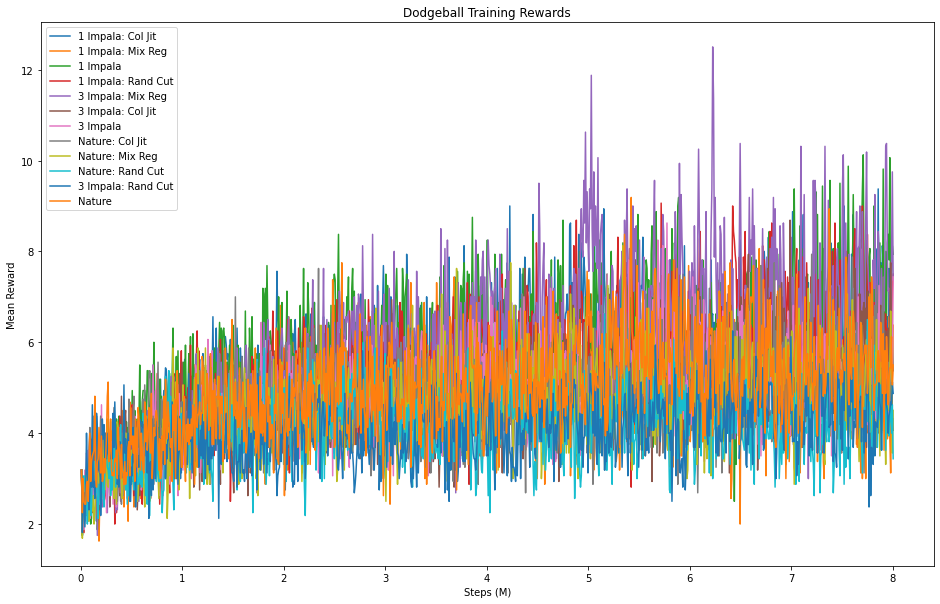

In [ ]:
plot_training_performance('Dodgeball')

Number of experiments done for Dodgeball: 12
Experiment names: ['sd_1_cj_db.pt', 'sd_1_mx_db.pt', 'sd_1_na_db.pt', 'sd_1_rc_db.pt', 'sd_i_mx_db.pt', 'sd_i_cj_db.pt', 'sd_i_na_db.pt', 'sd_n_cj_db.pt', 'sd_n_mx_db.pt', 'sd_n_rc_db.pt', 'sd_i_rc_db.pt', 'sd_n_na_db.pt']


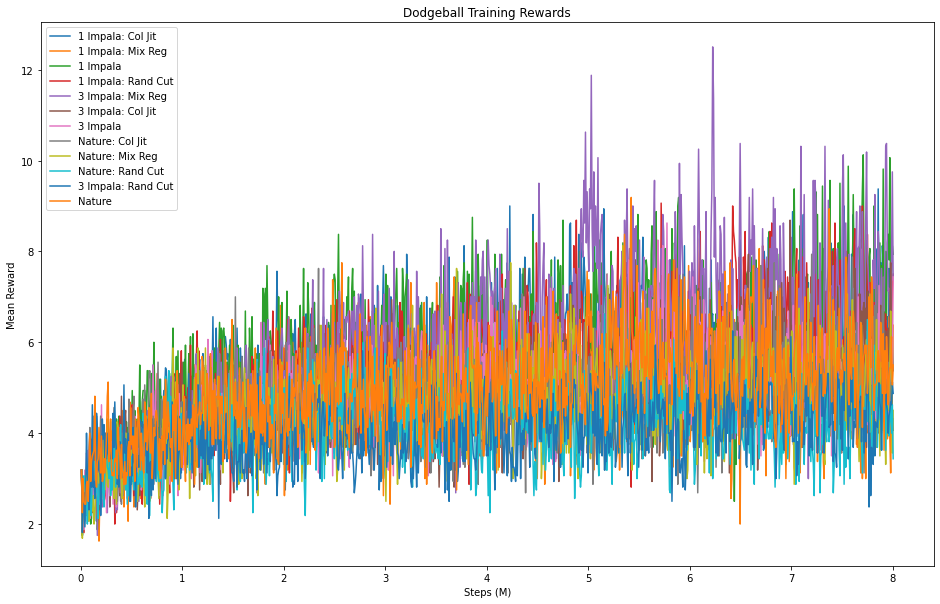

In [ ]:
plot_training_performance('Dodgeball')

In [ ]:
# Function that plots the total training time for each experiment of a specific game
def plot_training_time(game_name):
    path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

    # Get the stored training times for each experiment
    train_time = []
    experiment_names = []
    for filename in os.listdir(path):
        if filename.endswith(".pt"):
            experiment_names.append(filename)
            file_load = torch.load(path + filename)
            train_time.append(file_load['Training time'])
    train_time_hours = [t / (60*60) for t in train_time]
    experiment_names_decode = [decode_experiment_name(n) for n in experiment_names]
    print('Experiment names: ' + str(experiment_names))
    print('Total training time in hours: ' + str(train_time_hours))

    # Plot the results as a horizontal bar chart
    y_pos = np.arange(len(experiment_names))
    plt.barh(y_pos, train_time_hours, align='center', alpha=0.5)
    plt.yticks(y_pos, experiment_names_decode)
    plt.xlabel('Training time (h)')
    plt.title('Experiment total training time: ' + game_name)
    plt.show()

Experiment names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']
Total training time in hours: [3.3079904033078087, 4.563323624332746, 5.422584136194653, 10.358320200045904, 5.826158640715811, 5.7377575602796345, 4.432637404402097, 11.369051869776515, 5.132106360064612, 5.149689551989238, 3.1346346512768, 6.228966535594728, 3.930679434140523, 3.1083788128693897]


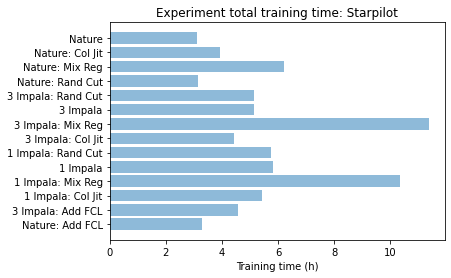

In [ ]:
plot_training_time('Starpilot')

Experiment names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']
Total training time in hours: [5.81216888487339, 7.473609013027615, 7.342604589992099, 10.238284490903219, 7.068233240379228, 6.960513810978996, 6.699508567253749, 7.000001176132097, 15.279248213039503, 5.757185348007414, 16.908389476736385, 6.558857562674416, 6.3017498461405435, 5.464028799732526]


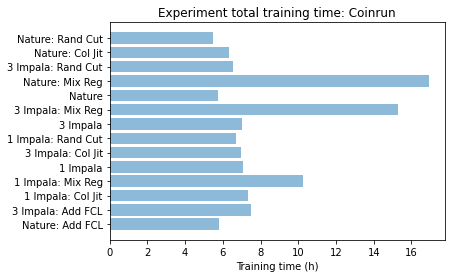

In [ ]:
plot_training_time('Coinrun')

Experiment names: ['sd_1_cj_db.pt', 'sd_1_mx_db.pt', 'sd_1_na_db.pt', 'sd_1_rc_db.pt', 'sd_i_mx_db.pt', 'sd_i_cj_db.pt', 'sd_i_na_db.pt', 'sd_n_cj_db.pt', 'sd_n_mx_db.pt', 'sd_n_rc_db.pt', 'sd_i_rc_db.pt', 'sd_n_na_db.pt']
Total training time in hours: [5.4398500658406155, 11.304989977081616, 4.592932974365023, 4.715564034978549, 15.272296250859897, 4.844670324921608, 5.37431334051821, 5.135147472023964, 6.990693134731717, 3.941386622455385, 5.416496101485358, 3.8092535025543635]


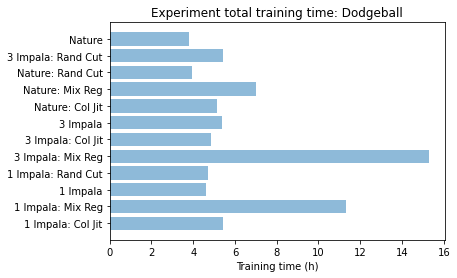

In [ ]:
plot_training_time('Dodgeball')

In [ ]:
# Define the necessary classes and functions for test performance
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class NatureEncoder(nn.Module):
    def __init__(self, in_channels, feature_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
        )
        self.apply(orthogonal_init)

    def forward(self, x):
        return self.layers(x)

class Policy(nn.Module):
    def __init__(self, encoder, feature_dim, num_actions):
        super().__init__()
        self.encoder = encoder
        self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
        self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

    def act(self, x):
        with torch.no_grad():
            x = x.cuda().contiguous()
            dist, value = self.forward(x)
            action = dist.sample()
            log_prob = dist.log_prob(action)
    
        return action.cpu(), log_prob.cpu(), value.cpu()

    def forward(self, x):
        x = self.encoder(x)
        logits = self.policy(x)
        value = self.value(x).squeeze(1)
        dist = torch.distributions.Categorical(logits=logits)

        return dist, value

class Policy_add_FCL(nn.Module):
    def __init__(self, encoder, feature_dim, num_actions):
        super().__init__()
        self.encoder = encoder
        self.policy_add_FCL = nn.Linear(feature_dim, int(feature_dim/2))
        self.policy = orthogonal_init(nn.Linear(int(feature_dim/2), num_actions), gain=.01)
        self.value_add_FCL = nn.Linear(feature_dim, int(feature_dim/2))
        self.value = orthogonal_init(nn.Linear(int(feature_dim/2), 1), gain=1.)

    def act(self, x):
        with torch.no_grad():
            x = x.cuda().contiguous()
            dist, value = self.forward(x)
            action = dist.sample()
            log_prob = dist.log_prob(action)
    
        return action.cpu(), log_prob.cpu(), value.cpu()

    def forward(self, x):
        x = self.encoder(x)
        pol_add = F.relu(self.policy_add_FCL(x))
        logits = self.policy(pol_add)
        val_add = F.relu(self.value_add_FCL(x))
        value = self.value(val_add).squeeze(1)
        dist = torch.distributions.Categorical(logits=logits)

        return dist, value

def xavier_uniform_init(module, gain=1.0):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight.data, gain)
        nn.init.constant_(module.bias.data, 0)
    return module

class ResidualBlock(nn.Module):
    def __init__(self,in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = nn.ReLU()(x)
        out = self.conv1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        return out + x

class ImpalaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImpalaBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.res1 = ResidualBlock(out_channels)
        self.res2 = ResidualBlock(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(x)
        x = self.res1(x)
        x = self.res2(x)
        return x

class ImpalaEncoder(nn.Module):
    def __init__(self,in_channels,out_features,**kwargs):
        super().__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=16)
        self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(in_features=32 * 8 * 8, out_features=out_features)

        self.output_dim = feature_dim
        self.apply(xavier_uniform_init)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = nn.ReLU()(x)
        x = Flatten()(x)
        x = self.fc(x)
        x = nn.ReLU()(x)
        return x

class Empala_Encoder_One(nn.Module):
    def __init__(self,in_channels,out_features,**kwargs):
        super().__init__()
        self.block1 = ImpalaBlock(in_channels=in_channels, out_channels=32)
        #self.block2 = ImpalaBlock(in_channels=16, out_channels=32)
        #self.block3 = ImpalaBlock(in_channels=32, out_channels=32)
        self.fc = nn.Linear(in_features=32 * 32 * 32, out_features=out_features)

        self.output_dim = out_features
        self.apply(xavier_uniform_init)

    def forward(self, x):
        x = self.block1(x)
        #x = self.block2(x)
        #x = self.block3(x)
        x = nn.ReLU()(x)
        x = Flatten()(x)
        x = self.fc(x)
        x = nn.ReLU()(x)
        return x

In [ ]:
# Function that plots the test mean reward for each experiment of a specific game
# There is also an option to save test videos for each experiment by setting 
# save_videos = True and supplying the path to save the videos
def plot_test_performance(game_name, save_videos=False, 
                              vid_path = r'/content/gdrive/MyDrive/Deep Learning Project 2020/Videos',
                              num_test_runs=1):
  # Get the stored policies for each experiment
  path = '/content/gdrive/MyDrive/Deep Learning Project 2020/Data/' + game_name + '/'

  policies = []
  experiment_names = []
  for filename in os.listdir(path):
    if filename.endswith(".pt"):
      experiment_names.append(filename)
      file_load = torch.load(path + filename)
      policies.append(file_load['policy_state_dict'])
  experiment_names_decode = [decode_experiment_name(n) for n in experiment_names]
  print('Experiment file names: ' + str(experiment_names))
  print('Experiment names: ' + str(experiment_names_decode))

  env = make_env(num_envs, num_levels=num_levels, env_name=game_name.lower())
  num_actions = env.action_space.n
  in_channels = env.observation_space.shape[0]

  # Run through testing num_test_runs times
  for j in range(num_test_runs):
    print(j)
    mean_rewards = []
    # Run through each experiment
    for i in range(len(experiment_names)):
      # Define the encoder used
      if experiment_names[i].split('_')[1] == 'i':
        encoder = ImpalaEncoder(in_channels, feature_dim)
      elif experiment_names[i].split('_')[1] == '1':
        encoder = Empala_Encoder_One(in_channels, feature_dim)
      else:
        encoder = NatureEncoder(in_channels, feature_dim)

      # Define and load the policy to use
      if experiment_names[i].split('_')[2] == 'addfc':
        policy = Policy_add_FCL(encoder, feature_dim, num_actions)
      else:
        policy = Policy(encoder, feature_dim, num_actions)
      policy.cuda()
      policy.load_state_dict(policies[i])

      # Now for evaluating generalization. We can generated a distinct test sets for each environment 
      # Make evaluation environment using levels that the models have not seen before
      eval_env = make_env(num_envs, start_level=num_levels*(j+1), num_levels=num_levels,
                          env_name=game_name.lower())
      obs = eval_env.reset()

      frames = []
      total_reward = []

      # Evaluate policy
      policy.eval()
      for _ in range(512):

        # Use policy
        action, log_prob, value = policy.act(obs)

        # Take step in environment
        obs, reward, done, info = eval_env.step(action)
        total_reward.append(torch.Tensor(reward))

        # Render environment and store
        frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
        frames.append(frame)

      # Calculate average return
      mean_reward = torch.stack(total_reward).sum(0).mean(0)
      mean_rewards.append(mean_reward.item())

      if(save_videos):
        # Store it in videos folder
        if not os.path.exists(vid_path):
          os.makedirs(vid_path)

        # Save frames as video
        frames = torch.stack(frames)
        imageio.mimsave(vid_path+'/vid_' + game_name + '_' + experiment_names_decode[i].replace(' ', '') + '.mp4', frames, fps=25)
    print('Mean test rewards: ' + str(mean_rewards))

    # Plot the results as a horizontal bar chart
    y_pos = np.arange(len(experiment_names))
    plt.barh(y_pos, mean_rewards, align='center', alpha=0.5)
    plt.yticks(y_pos, experiment_names_decode)
    plt.xlabel('Mean Reward')
    plt.title(game_name + ' Experiment Mean Test Rewards')
    plt.show()

Experiment file names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']
Experiment names: ['Nature: Add FCL', '3 Impala: Add FCL', '1 Impala: Col Jit', '1 Impala: Mix Reg', '1 Impala', '1 Impala: Rand Cut', '3 Impala: Col Jit', '3 Impala: Mix Reg', '3 Impala', '3 Impala: Rand Cut', 'Nature: Rand Cut', 'Nature: Mix Reg', 'Nature: Col Jit', 'Nature']
Mean test rewards: [18.248615264892578, 18.646053314208984, 16.97902488708496, 18.656320571899414, 18.08676528930664, 18.214447021484375, 19.037227630615234, 18.782001495361328, 19.295551300048828, 19.378238677978516, 18.327667236328125, 18.339460372924805, 17.517921447753906, 19.008737564086914]


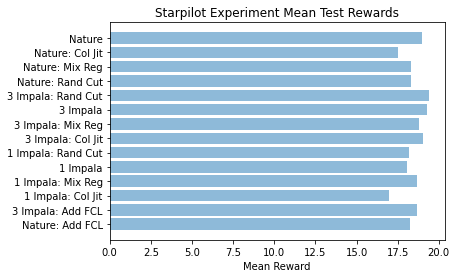

In [ ]:
plot_test_performance('Starpilot', False, num_test_runs=1)

Experiment file names: ['sd_n_addfc_sp.pt', 'sd_i_addfc_sp.pt', 'sd_1_cj_sp.pt', 'sd_1_mx_sp.pt', 'sd_1_na_sp.pt', 'sd_1_rc_sp.pt', 'sd_i_cj_sp.pt', 'sd_i_mx_sp.pt', 'sd_i_na_sp.pt', 'sd_i_rc_sp.pt', 'sd_n_rc_sp.pt', 'sd_n_mx_sp.pt', 'sd_n_cj_sp.pt', 'sd_n_na_sp.pt']
Experiment names: ['Nature: Add FCL', '3 Impala: Add FCL', '1 Impala: Col Jit', '1 Impala: Mix Reg', '1 Impala', '1 Impala: Rand Cut', '3 Impala: Col Jit', '3 Impala: Mix Reg', '3 Impala', '3 Impala: Rand Cut', 'Nature: Rand Cut', 'Nature: Mix Reg', 'Nature: Col Jit', 'Nature']
0
Mean test rewards: [18.248615264892578, 18.646053314208984, 16.97902488708496, 18.656320571899414, 18.08676528930664, 18.214447021484375, 19.037227630615234, 18.782001495361328, 19.295551300048828, 19.378238677978516, 18.327667236328125, 18.339460372924805, 17.517921447753906, 19.008737564086914]


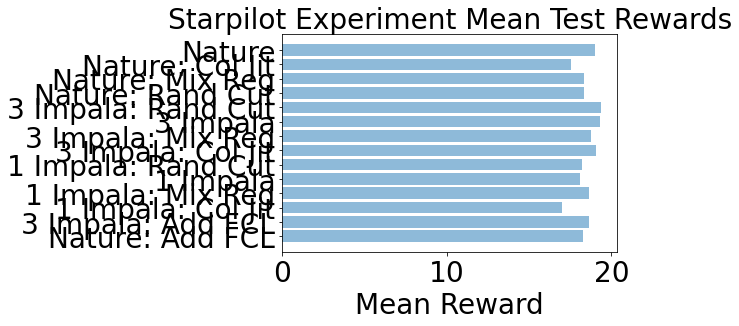

1
Mean test rewards: [18.426918029785156, 18.794240951538086, 18.27177619934082, 19.031557083129883, 18.5661678314209, 18.907690048217773, 18.79686164855957, 18.898021697998047, 20.245338439941406, 19.164819717407227, 18.609973907470703, 18.13841438293457, 18.514829635620117, 18.201440811157227]


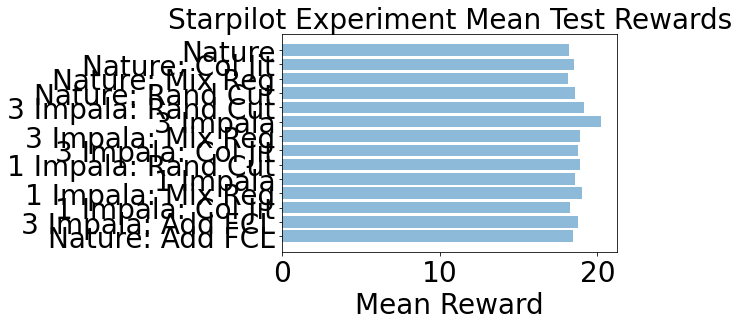

2
Mean test rewards: [17.137847900390625, 19.932851791381836, 18.72010040283203, 19.69651222229004, 18.660240173339844, 18.4227294921875, 18.944732666015625, 18.779212951660156, 20.0130558013916, 20.394954681396484, 18.5064640045166, 17.80097770690918, 18.376022338867188, 17.695608139038086]


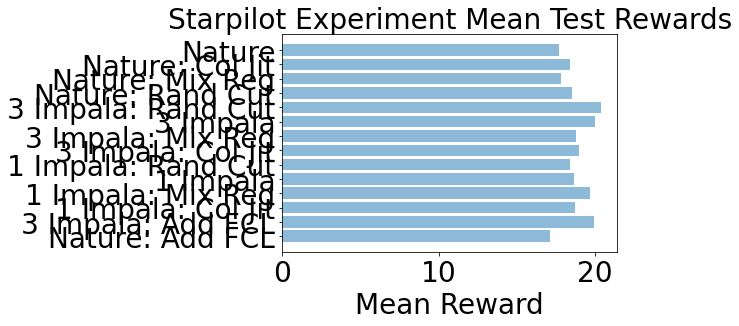

3
Mean test rewards: [17.946548461914062, 18.502071380615234, 17.121198654174805, 18.32259750366211, 17.973735809326172, 19.279876708984375, 19.14911460876465, 19.704404830932617, 18.864961624145508, 19.985305786132812, 17.3320255279541, 17.832454681396484, 16.50645637512207, 18.424543380737305]


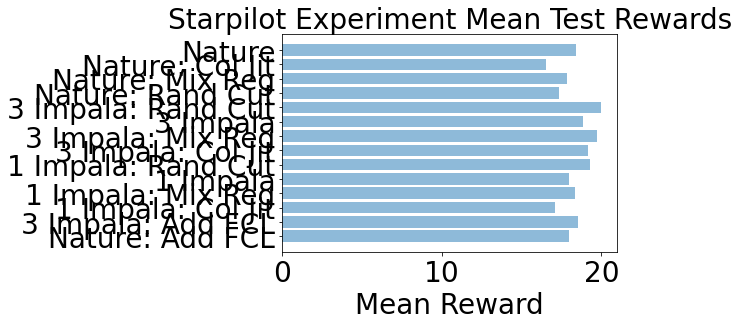

In [ ]:
plot_test_performance('Starpilot', False, num_test_runs=4)

Experiment file names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']
Experiment names: ['Nature: Add FCL', '3 Impala: Add FCL', '1 Impala: Col Jit', '1 Impala: Mix Reg', '1 Impala', '3 Impala: Col Jit', '1 Impala: Rand Cut', '3 Impala', '3 Impala: Mix Reg', 'Nature', 'Nature: Mix Reg', '3 Impala: Rand Cut', 'Nature: Col Jit', 'Nature: Rand Cut']
Mean test rewards: [63.207496643066406, 56.034358978271484, 55.88566589355469, 63.11048126220703, 64.85433197021484, 60.24873352050781, 55.0936279296875, 63.605506896972656, 62.010562896728516, 61.39104461669922, 62.45901870727539, 53.3888053894043, 57.703346252441406, 53.81644058227539]


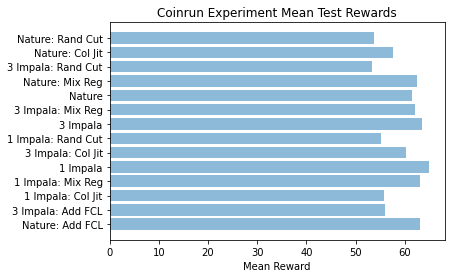

In [ ]:
plot_test_performance('Coinrun', False, num_test_runs=1)

Experiment file names: ['sd_n_addfc_cr.pt', 'sd_i_addfc_cr.pt', 'sd_1_cj_cr.pt', 'sd_1_mx_cr.pt', 'sd_1_na_cr.pt', 'sd_i_cj_cr.pt', 'sd_1_rc_cr.pt', 'sd_i_na_cr.pt', 'sd_i_mx_cr.pt', 'sd_n_na_cr.pt', 'sd_n_mx_cr.pt', 'sd_i_rc_cr.pt', 'sd_n_cj_cr.pt', 'sd_n_rc_cr.pt']
Experiment names: ['Nature: Add FCL', '3 Impala: Add FCL', '1 Impala: Col Jit', '1 Impala: Mix Reg', '1 Impala', '3 Impala: Col Jit', '1 Impala: Rand Cut', '3 Impala', '3 Impala: Mix Reg', 'Nature', 'Nature: Mix Reg', '3 Impala: Rand Cut', 'Nature: Col Jit', 'Nature: Rand Cut']
0
Mean test rewards: [63.207496643066406, 56.034358978271484, 55.88566589355469, 63.11048126220703, 64.85433197021484, 60.24873352050781, 55.0936279296875, 63.605506896972656, 62.010562896728516, 61.39104461669922, 62.45901870727539, 53.3888053894043, 57.703346252441406, 53.81644058227539]


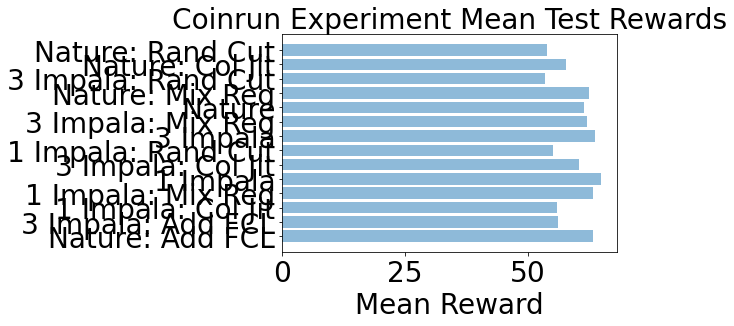

1
Mean test rewards: [62.28023910522461, 58.79818344116211, 53.54679870605469, 61.59008026123047, 57.226436614990234, 58.77120590209961, 54.38863754272461, 56.504661560058594, 58.66029357910156, 61.7890625, 58.03361129760742, 56.31614685058594, 54.13187789916992, 49.433040618896484]


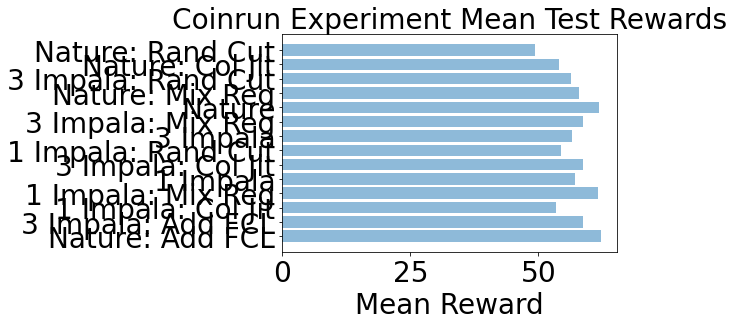

2
Mean test rewards: [63.13134765625, 59.0621223449707, 54.946083068847656, 67.88497161865234, 63.03694152832031, 64.9459228515625, 55.31230926513672, 62.542049407958984, 62.08978271484375, 63.17876434326172, 57.52705001831055, 56.82017135620117, 61.30410385131836, 53.87277603149414]


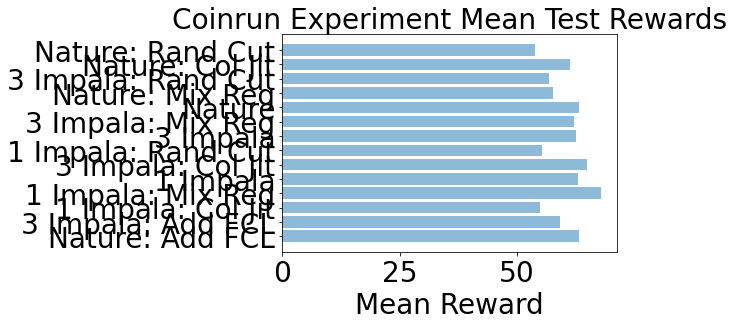

3
Mean test rewards: [62.34994125366211, 59.71719741821289, 57.38587951660156, 63.14024353027344, 60.46234130859375, 63.86140441894531, 53.59275817871094, 58.19513702392578, 57.60649108886719, 61.81005859375, 57.323326110839844, 58.292724609375, 56.662235260009766, 52.79945755004883]


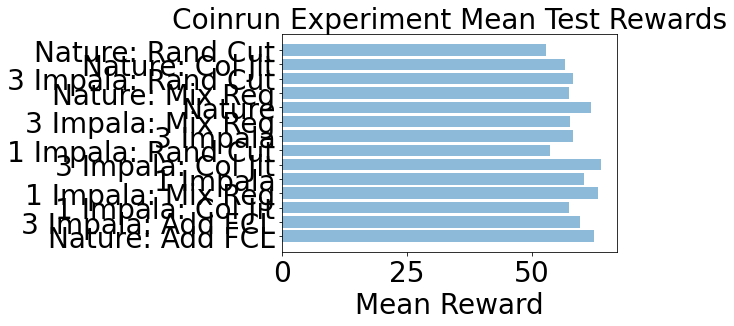

In [ ]:
plot_test_performance('Coinrun', False, num_test_runs=4)

Experiment file names: ['sd_1_cj_db.pt', 'sd_1_mx_db.pt', 'sd_1_na_db.pt', 'sd_1_rc_db.pt', 'sd_i_mx_db.pt', 'sd_i_cj_db.pt', 'sd_i_na_db.pt', 'sd_n_cj_db.pt', 'sd_n_mx_db.pt', 'sd_n_rc_db.pt', 'sd_i_rc_db.pt', 'sd_n_na_db.pt']
Experiment names: ['1 Impala: Col Jit', '1 Impala: Mix Reg', '1 Impala', '1 Impala: Rand Cut', '3 Impala: Mix Reg', '3 Impala: Col Jit', '3 Impala', 'Nature: Col Jit', 'Nature: Mix Reg', 'Nature: Rand Cut', '3 Impala: Rand Cut', 'Nature']
Mean test rewards: [7.510704517364502, 11.229819297790527, 7.836635112762451, 7.811717510223389, 12.4534330368042, 7.754740238189697, 8.683810234069824, 8.669076919555664, 8.86596393585205, 9.414883613586426, 8.385702133178711, 7.795169353485107]


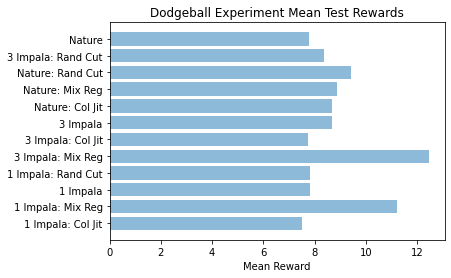

In [ ]:
plot_test_performance('Dodgeball', True)

## End of notebook